# Results Explorer for pendulum models

includes plotting the sindy coefficients $\Xi$, loss metrics and trajectories for different initial conditions 

### Choose Model

In [1]:
#CHOOSE MODEL
model_path = "KathleenReplicas/version_6"
#CHOOSE MODEL
#good versions
#version_3
#version_6

In [2]:
import sys
sys.path.append('../')
from trainer import SINDy_trainer, update_mask
import jax.numpy as jnp
import numpy as np

# if we are not training any further the example input can be any shape
exmp_input = jnp.ones((1, 128))
trainer = SINDy_trainer.load_from_checkpoint(model_path, exmp_input)

xi_raw = trainer.state.params['sindy_coefficients']


mask = update_mask(xi_raw)

library_hparams = trainer.library_hparams

xi = xi_raw * mask


xi = np.array(xi)


2024-06-14 16:09:54.173596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
print(xi.shape)

(12, 1)


### Printing discovered equations

In [4]:
import matplotlib.pyplot as plt
from sindyLibrary import get_row_context

row_context = get_row_context(library_hparams)

lib_size, n_states = xi.shape

text = r"$$ \begin{align*}"

for i in range(n_states):
    first = True
    text += r"\dot{z}_" + f"{i+1}" + r" =& "
    for (x, y) in zip(xi, row_context):
        coeff = x[i]
        if coeff != 0:
            if coeff > 0 and not first:
                text += "+"
            text += f"{coeff:.2f} {y}"
            first = False
    text += r"\\"

text += r"\end{align*} $$"
from IPython.display import display, Latex
display(Latex(text))
    

<IPython.core.display.Latex object>

### Plotting $\Xi$

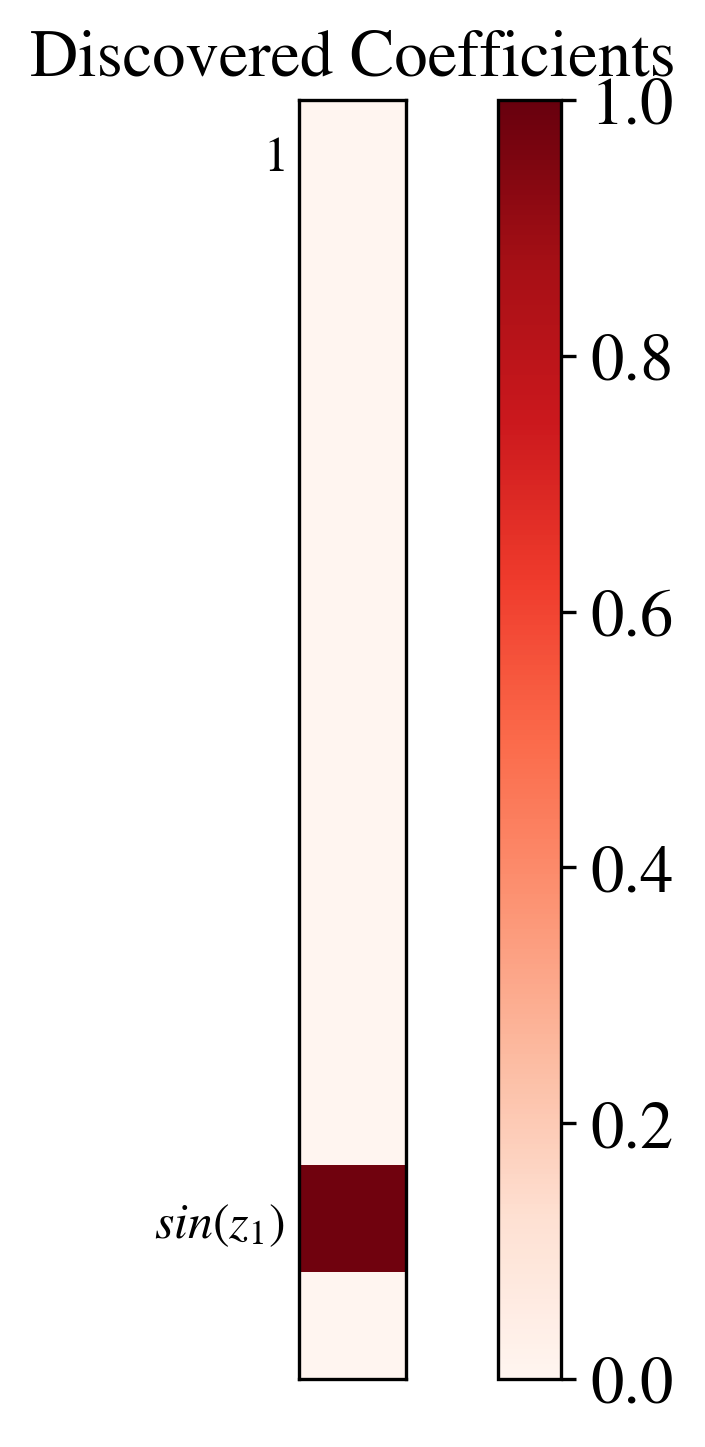

In [6]:
# sys.path.append('../plot_utils')
import matplotlib.pyplot as plt
from plot_utils.plot_xi import plot_sindy_coefficients


plt.style.use("../plot_utils/plot_settings.mplstyle")
plot_sindy_coefficients(xi, library_hparams = library_hparams, file_name="xi_plot.png", second_order=True)

### Plot difference between discovered coefficients ($\Xi$) and actual coefficients

#### True equation

\begin{equation}
\ddot{z} = -sin(z)
\end{equation}



In [7]:
# Should look into generalizing this if we want to use it for all models

true_xi = np.zeros(12)
true_xi[-2] = -1
true_xi = true_xi.reshape(12, 1)


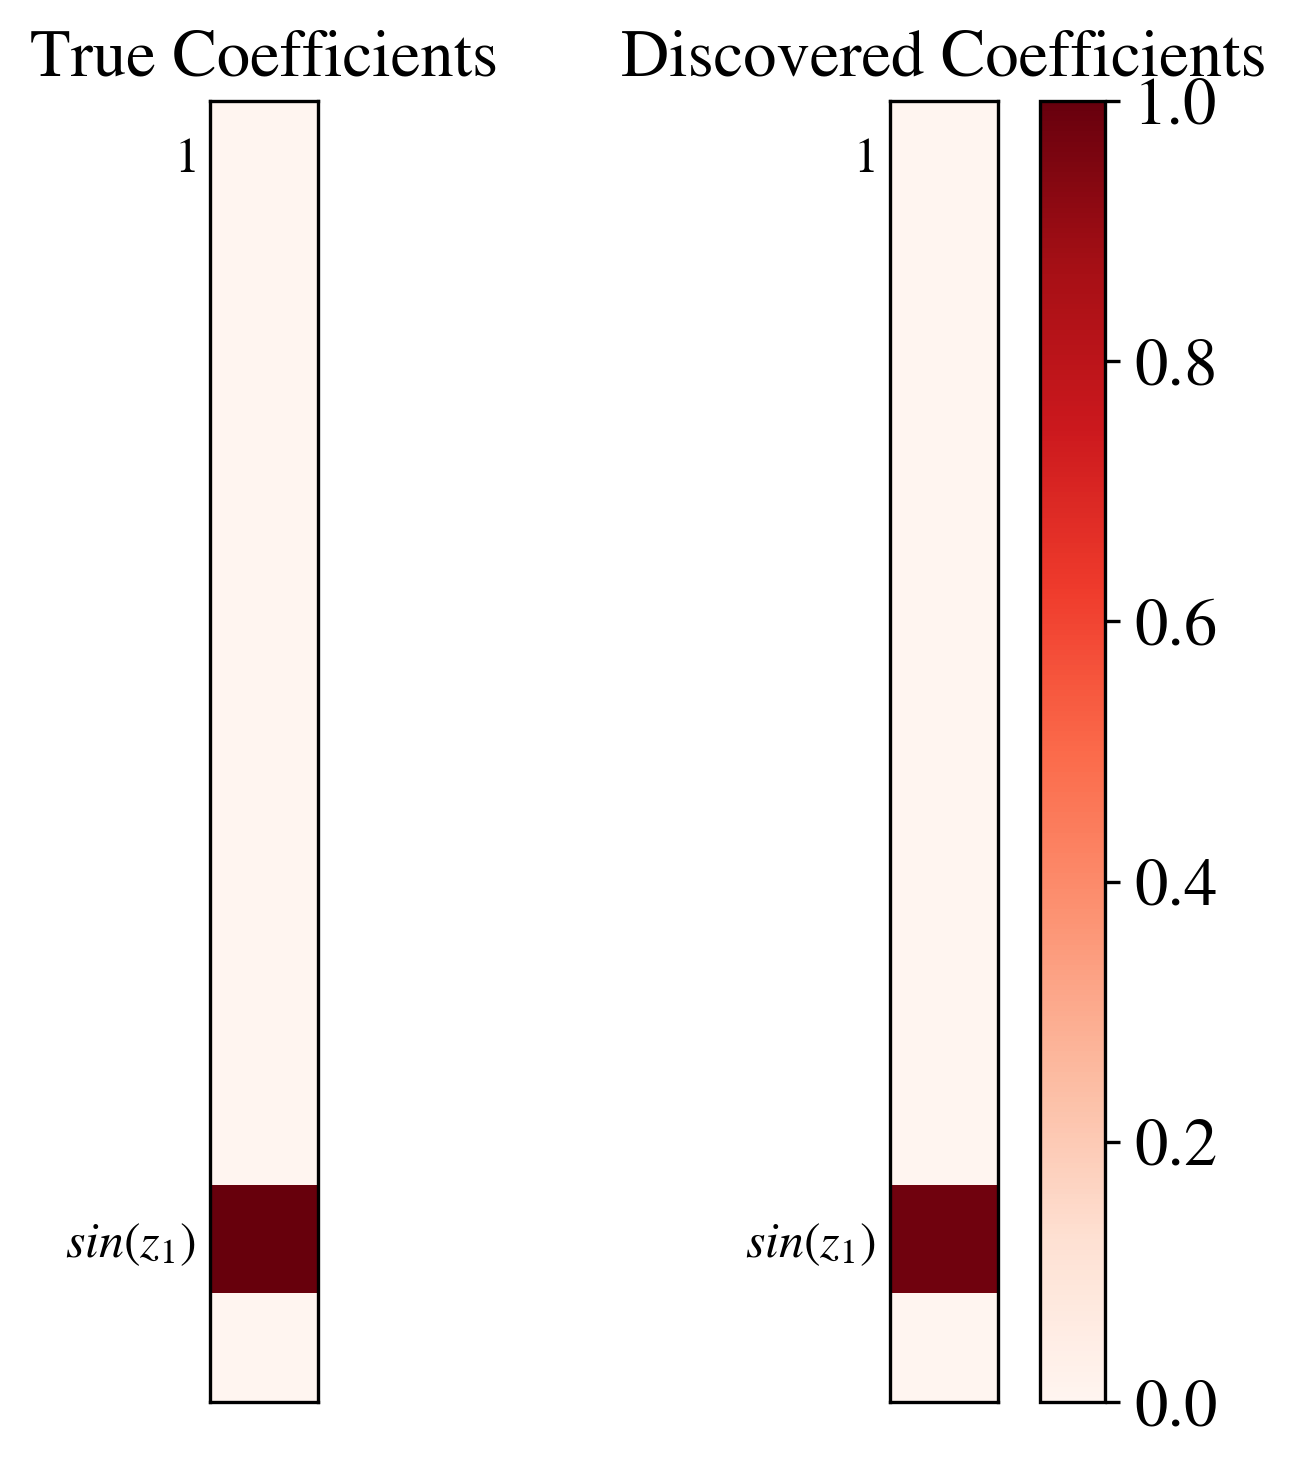

In [8]:
from plot_utils.plot_xi import compare_sindy_coefficients

plt.style.use("../plot_utils/plot_settings.mplstyle")
compare_sindy_coefficients(true_xi, xi, library_hparams = library_hparams, save_path="xi_plot.png")

### Plot losses

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


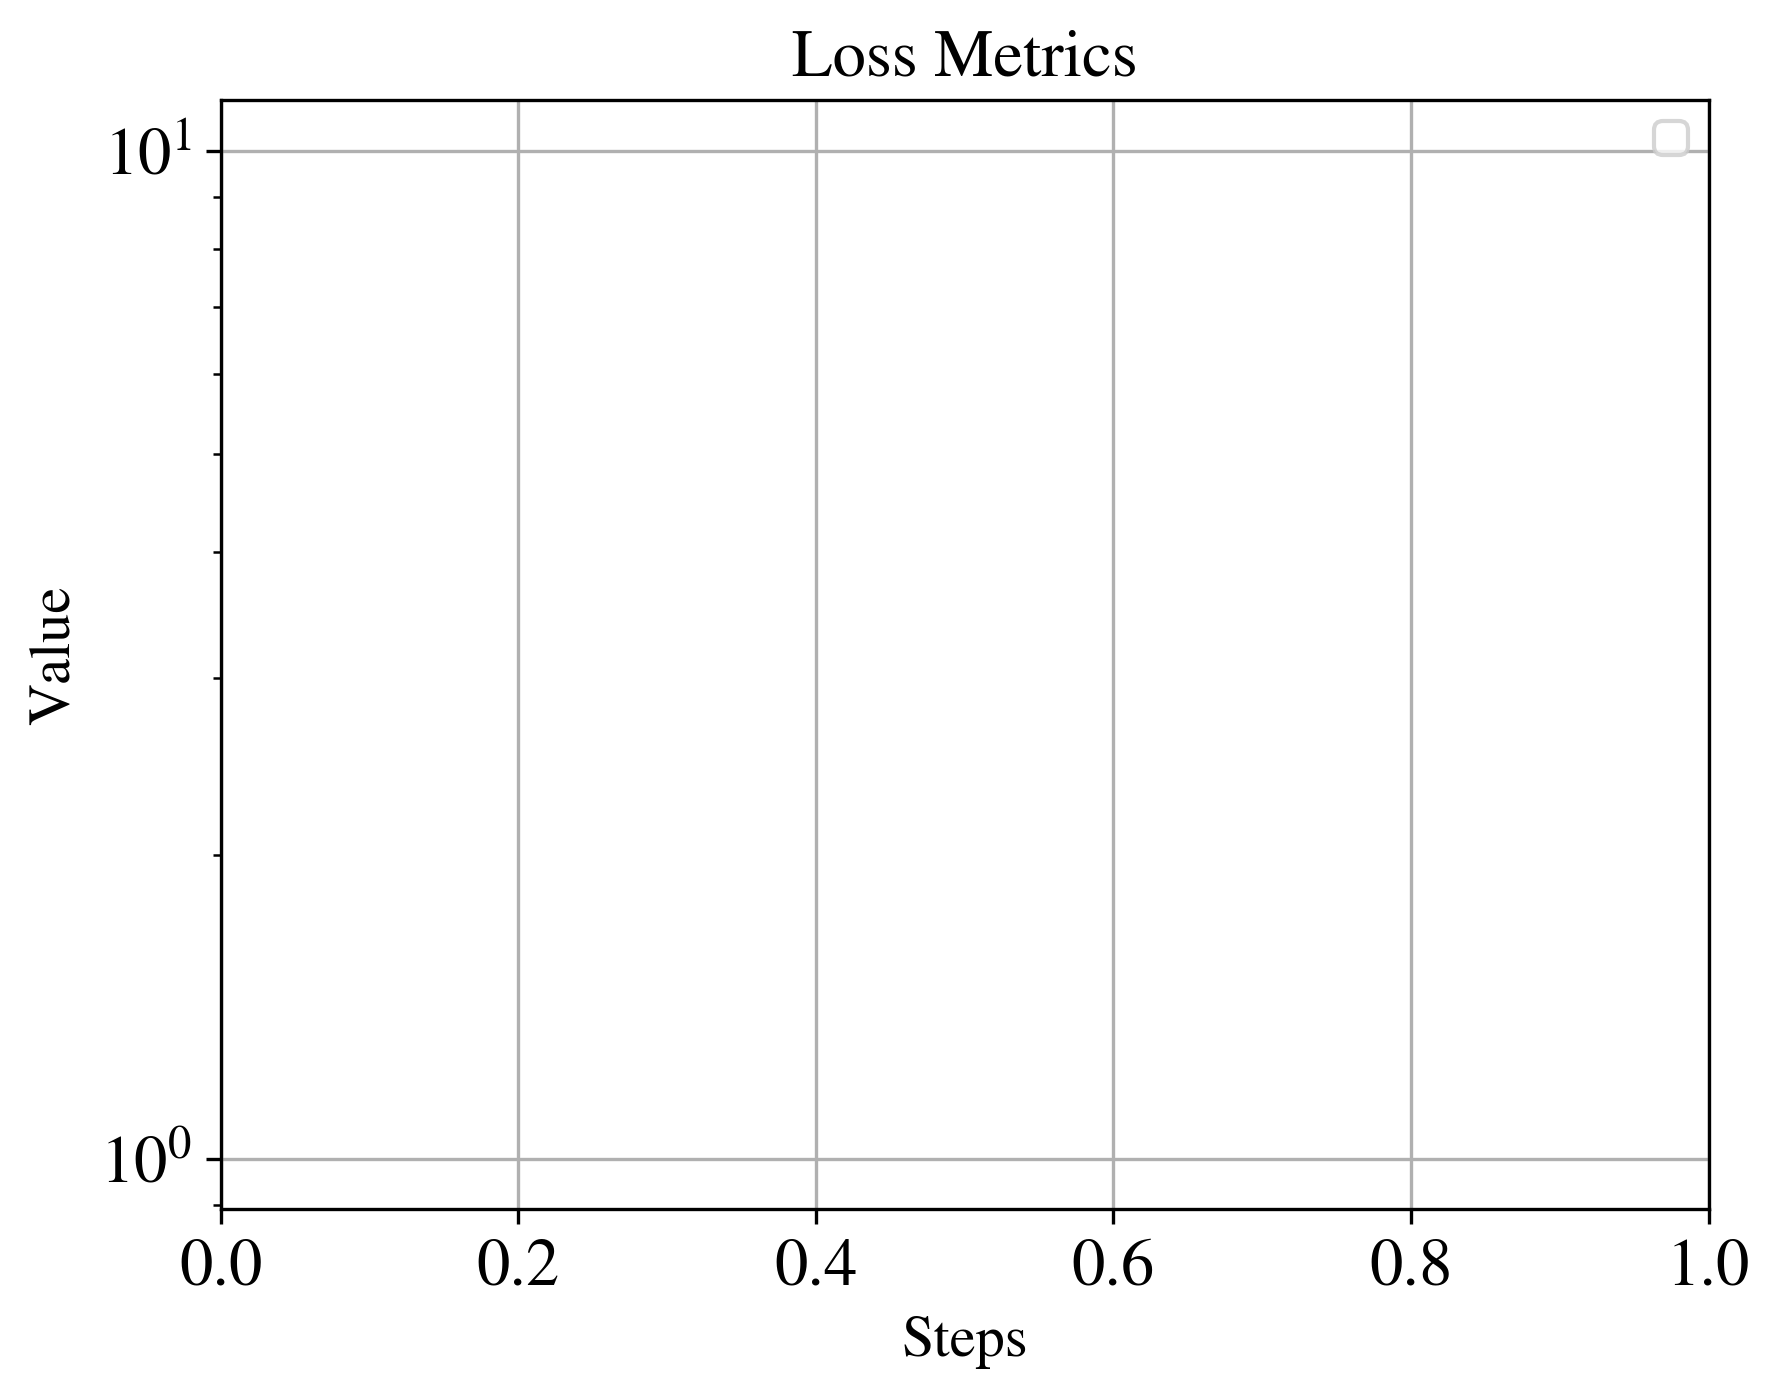

In [8]:
import sys
sys.path.append('..')
from plot_utils.metrics import RunMetrics 
from plot_utils.plot_metrics import plot_metrics 


metrics = RunMetrics(model_path)

# Plot a single run
plot_metrics(metrics, metric_names=["train/loss", "val/loss"], title="Loss Metrics")

### Plotting results

We compare $z$ and $\dot{z}$

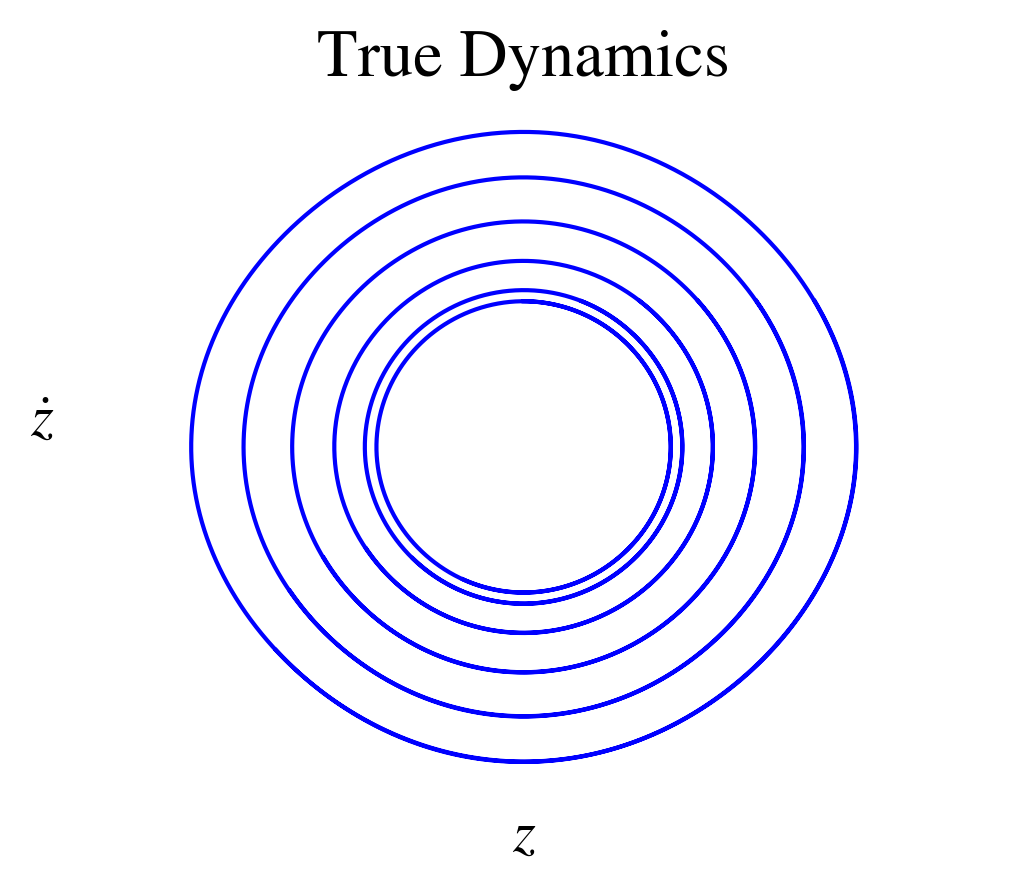

In [9]:
from sindySimulate import sindy_simulate_order2
from pendulumSimulate import plot_z_zdot

# Simulation parameters
z_0 = np.array([0])
dz_0 = np.array([0.5])

time = np.linspace(0, 10, 1000)

all_z_sims = np.array([sindy_simulate_order2(z_0, dz_0, time, true_xi, **library_hparams)])
for i in range(2, 11, 2):
    z_0 = np.array([i/10])
    z_sim = sindy_simulate_order2(z_0, dz_0, time, true_xi, **library_hparams)
    all_z_sims = np.concatenate([all_z_sims, np.array([z_sim])])

plot_z_zdot(all_z_sims, title="True Dynamics")

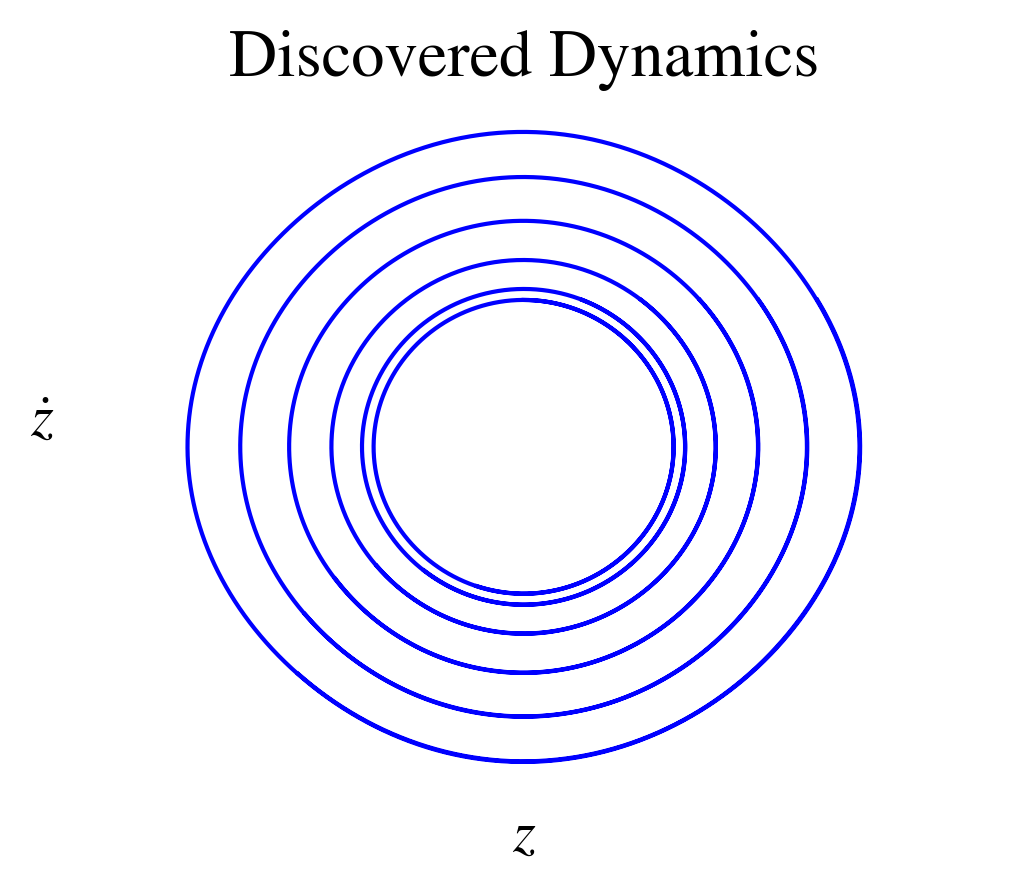

In [10]:
z_0 = np.array([0])
dz_0 = np.array([0.5])

all_z_sims = np.array([sindy_simulate_order2(z_0, dz_0, time, xi, **library_hparams)])
for i in range(2, 11, 2):
    z_0 = np.array([i/10])
    z_sim = sindy_simulate_order2(z_0, dz_0, time, xi, **library_hparams)
    all_z_sims = np.concatenate([all_z_sims, np.array([z_sim])])

plot_z_zdot(all_z_sims, title="Discovered Dynamics")

Text(0.5, 1.0, 'Discovered Dynamics')

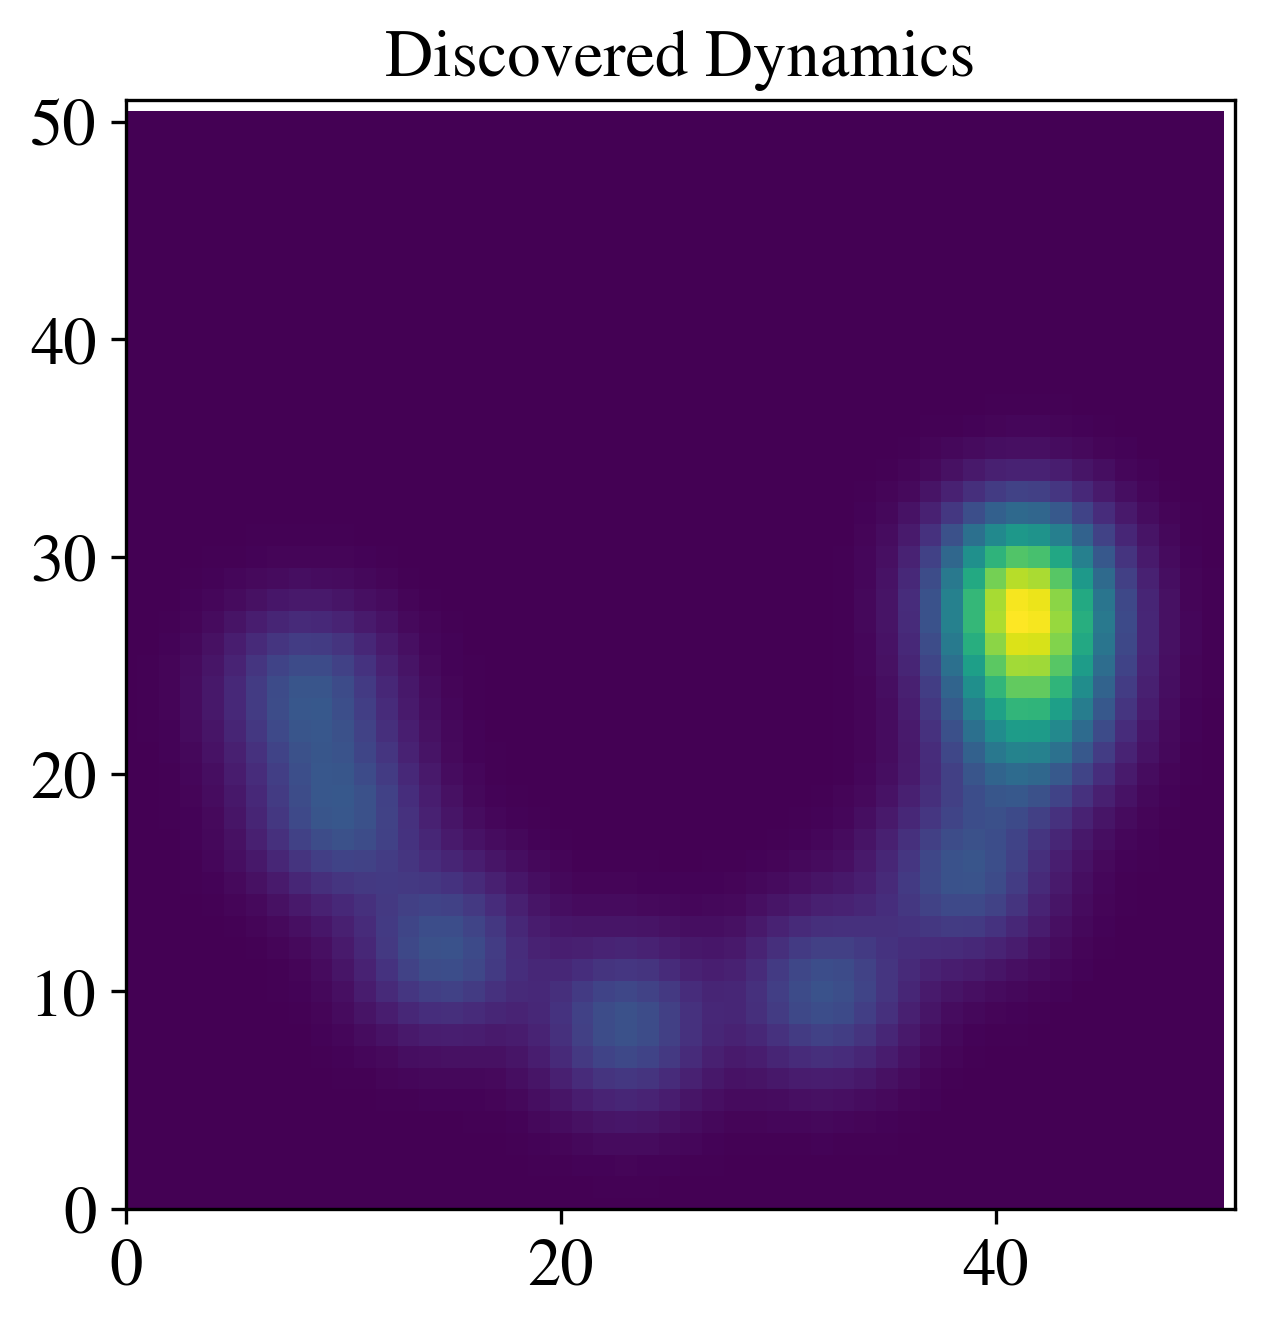

In [21]:
from pendulumData import pendulum_to_movie

z_0 = np.array([1.5])
dz_0 = np.array([0.8])

time = np.linspace(0, 4, 12)

z_sim = sindy_simulate_order2(z_0, dz_0, time, xi, **library_hparams)

x, dx, ddx = pendulum_to_movie(np.array([z_sim]), np.array([z_sim]))

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim((0, 51))
ax.set_ylim((0, 51))

x_image = np.zeros_like(x[0,0])
for sample in x[0]:
    x_image += sample


image = ax.imshow(x_image, cmap='viridis', interpolation='none')
ax.set_title("Discovered Dynamics")

Text(0.5, 1.0, 'Actual Dynamics')

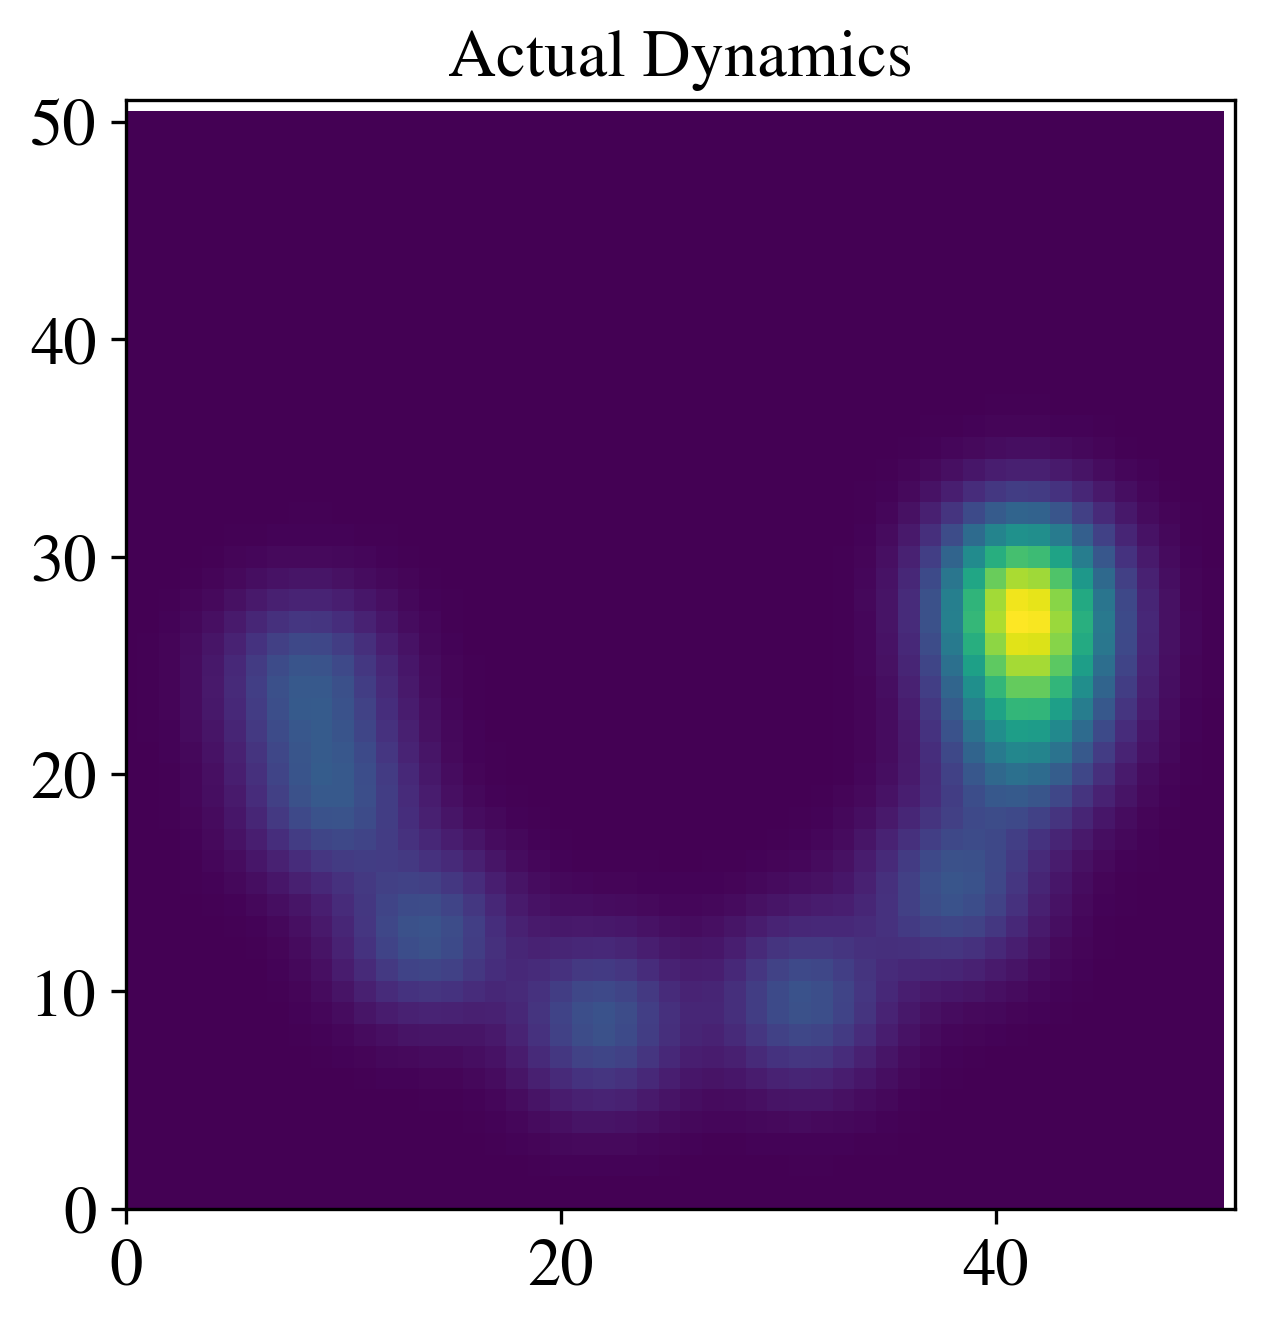

In [20]:
true_z_sim = sindy_simulate_order2(z_0, dz_0, time, true_xi, **library_hparams)

x, dx, ddx = pendulum_to_movie(np.array([true_z_sim]), np.array([true_z_sim]))

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim((0, 51))
ax.set_ylim((0, 51))

x_image = np.zeros_like(x[0,0])
for sample in x[0]:
    x_image += sample


image = ax.imshow(x_image, cmap='viridis', interpolation='none')
ax.set_title("Actual Dynamics")